In [47]:
import os
import pandas as pd 
import numpy as np 
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("ImageDataGenerator imported successfully ✅")


# --- Check working directory and folder structure ---
print("Current working dir:", os.getcwd())
print("Top-level files/folders in CWD:", os.listdir())
print("Is there a folder named 'dataset' here?", os.path.isdir('dataset'))
print("Is there a folder named 'alzheimers-dataset' here?", os.path.isdir('alzheimers-dataset'))
print("Does 'dataset/train' exist?", os.path.isdir('dataset/train'))
print("Does 'alzheimers-dataset/train' exist?", os.path.isdir('alzheimers-dataset/train'))

# --- Folder setup ---
default_dir = "dataset/"
root_dir = "./"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset_copy/"

# Delete old dataset folder if it exists
if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)

print("Working Directory Contents:", os.listdir(work_dir))

# --- Class labels ---
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# --- Image configuration ---
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)


ImageDataGenerator imported successfully ✅
Current working dir: c:\projects\Alzheimers-disease-detection
Top-level files/folders in CWD: ['.git', 'alzheimer-detection.ipynb', 'app2.py', 'dataset', 'dataset_copy', 'images', 'my_model.h5', 'Pdf_reports', 'README.md', 'tempCodeRunnerFile.ipynb']
Is there a folder named 'dataset' here? True
Is there a folder named 'alzheimers-dataset' here? False
Does 'dataset/train' exist? True
Does 'alzheimers-dataset/train' exist? False
Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [48]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [49]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 6400 images belonging to 4 classes.


## Visualization

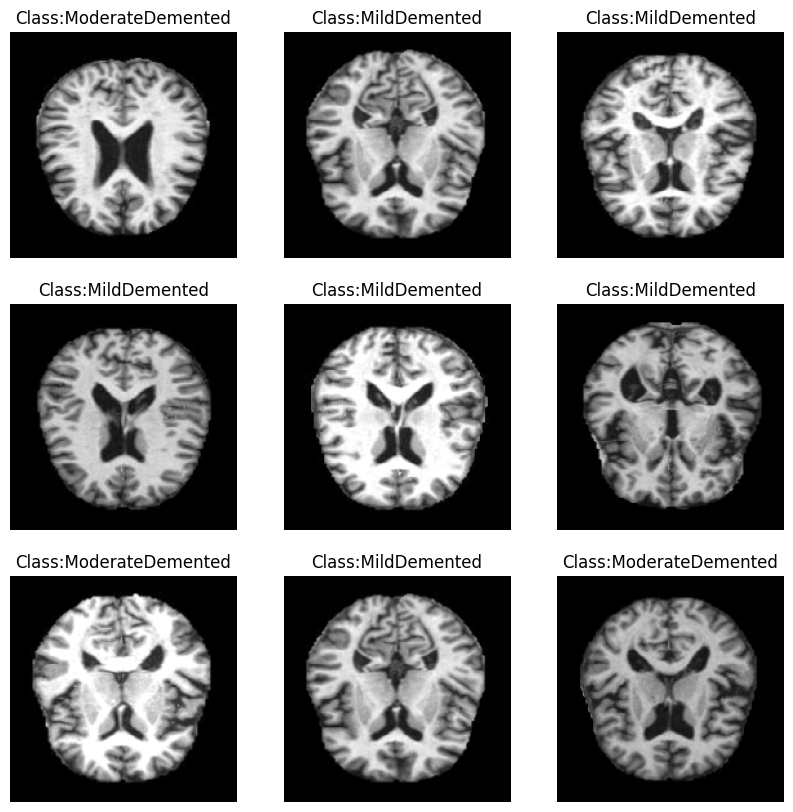

In [50]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x, y = next(generator)

    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

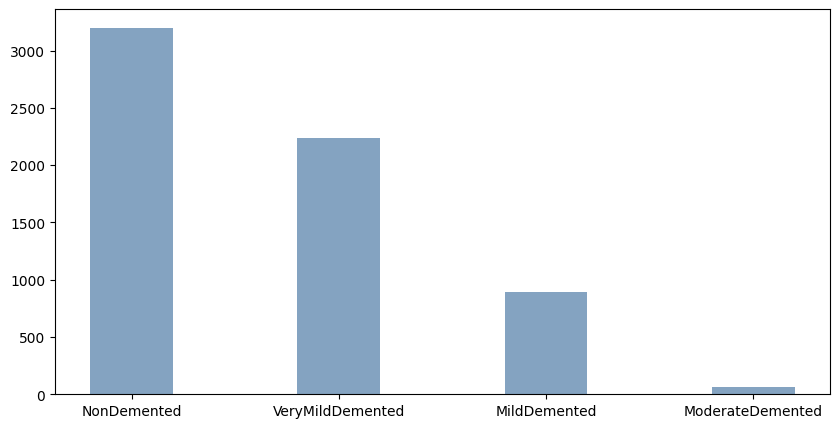

In [51]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [52]:
train_data, train_labels = next(train_dataset)

In [53]:
print(train_data.shape, train_labels.shape)

(1200, 176, 176, 3) (1200, 4)


In [54]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2428, 176, 176, 3) (2428, 4)


In [55]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [56]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

c:\Users\saksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [58]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 333ms/step - acc: 0.2531 - auc: 0.5090 - loss: 2.0035 - val_acc: 0.2031 - val_auc: 0.4679 - val_loss: 1.3976
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - acc: 0.2898 - auc: 0.5565 - loss: 1.7313 - val_acc: 0.2699 - val_auc: 0.5189 - val_loss: 1.3856
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - acc: 0.3580 - auc: 0.6127 - loss: 1.5436 - val_acc: 0.2725 - val_auc: 0.5373 - val_loss: 1.3882
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - acc: 0.4507 - auc: 0.7092 - loss: 1.2987 - val_acc: 0.2545 - val_auc: 0.5274 - val_loss: 1.3908
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - acc: 0.5113 - auc: 0.7919 - loss: 1.0828 - val_acc: 0.2545 - val_auc: 0.5352 - val_loss: 1.4021
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - acc: 0.5422 - auc: 0.8217 - loss: 0.9989 - val_acc: 0.2545 - val_auc: 0.5256 - val_loss: 1.4107
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - acc: 0.5937 - auc: 0.8571 - loss: 0.886

In [59]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - acc: 0.7119 - auc: 0.8862 - loss: 1.2452
Loss:  1.2452412843704224
Accuracy:  0.7119341492652893


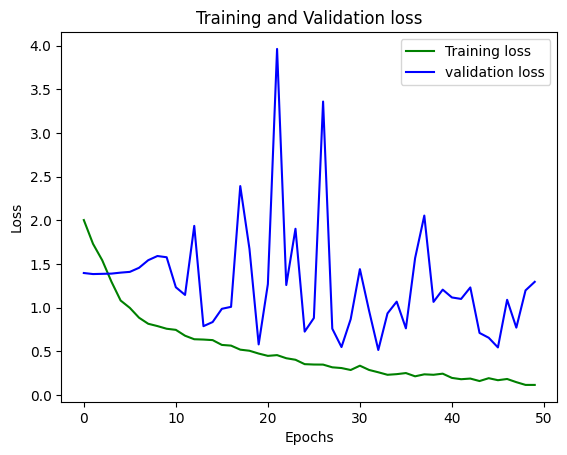

In [60]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

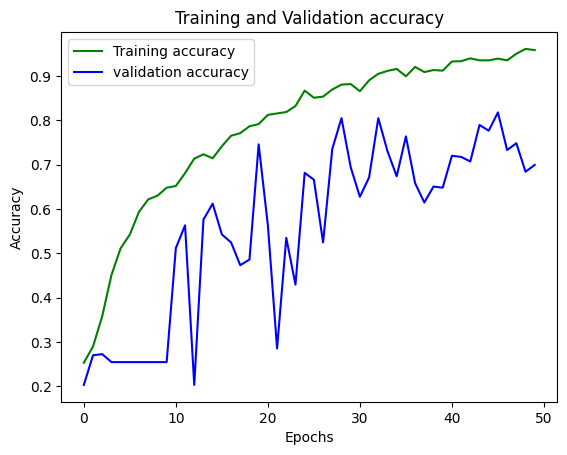

In [61]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [62]:
model.save('my_model.h5')